# 4강. 어제 오른 내 주식, 과연 내일은?

## 1. 시계열예측

- 안정적(Stationary) 데이터에 대해서만 미래 예측이 가능하다.
즉, 과거의 데이터에서 일정한 패턴이 발견되고 그 패턴이 미래에도 동일하게 반복되어 시계열 데이터의 통계적 특성이 변하지 않는 경우 가능하다.
- 안정적인 시계열에서 시간의 추이와 관계없이 일정해야 하는 통계적 특성 : 평균, 분산, 자기공분산
- [Covariance(공분산), Correlation(상관계수)](https://destrudo.tistory.com/15) : 두 확률변수 X, Y변수의 분포가 서로 얼마나 상관성을 가지는지 나타내는 지표  
Covariance : 각 확률변수들이 어떻게 퍼져있는지 나타내는 것. 관계를 나타내는 것. X, Y변수의 단위 크기에 영향을 받기 때문에 그 값 자체가 두 변수 간의 상관성을 직접적으로 대표하지는 못한다.  
Correlation : Covariance를 보완하기 위해 Covariance를 Nomalize하여 두 변수 간의 상관성이 항상 -1에서 1사이의 값으로 표현되도록 보정한 것.
- 자기와의 공분산 = 분산 = 자기공분산(일정 시차 h 사이를 둔 자기자신과의 공분산)
- 두 확률변수 X, Y가 서로 독립이면 Covariance와 Correlation은 모두 0이 된다.

## (1) Daily Minimum Temperatures in Melbourne 시계열 데이터 다루기

In [1]:
!mkdir -p ~/aiffel/stock_prediction/data
!ln -s ~/data/* ~/aiffel/stock_prediction/data

ln: failed to create symbolic link '/aiffel/aiffel/stock_prediction/data/005930.KS.csv': File exists
ln: failed to create symbolic link '/aiffel/aiffel/stock_prediction/data/airline-passengers.csv': File exists
ln: failed to create symbolic link '/aiffel/aiffel/stock_prediction/data/daily-min-temperatures.csv': File exists


### 시계열(Time Series) 생성

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import warnings
warnings.filterwarnings('ignore')

In [3]:
dataset_filepath = os.getenv('HOME')+'/aiffel/stock_prediction/data/daily-min-temperatures.csv' 
df = pd.read_csv(dataset_filepath) 
print(type(df))
df.head()

<class 'pandas.core.frame.DataFrame'>


,Date,Temp
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8


In [4]:
# Date컬럼을 index로 삼아 시계열 생성 
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
print(type(df)) # type이 DataFrame
df.head()

<class 'pandas.core.frame.DataFrame'>


,Temp
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8


In [5]:
ts1 = df['Temp'] # time series ='ts'
print(type(ts1)) # type이 Series
ts1.head()

<class 'pandas.core.series.Series'>


Date
1981-01-01    20.7
1981-01-02    17.9
1981-01-03    18.8
1981-01-04    14.6
1981-01-05    15.8
Name: Temp, dtype: float64

DataFrame인 df와 Series인 df['Temp']는 index 구조가 동일하므로 Numpy, Pandas, Matplotlib 등 많은 라이브러리들이 호환해서 지원된다. 하지만 그렇지 않은 경우도 존재한다.

### 시계열 안정성의 정성적 분석

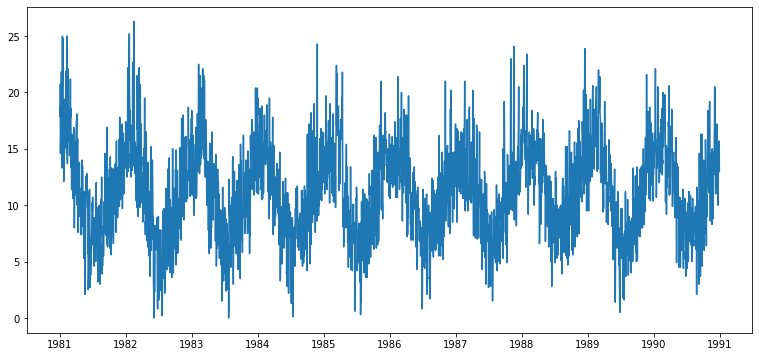

In [6]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6    # matlab 차트의 기본 크기를 13, 6으로 지정

# 시계열(time series) 데이터를 차트로 그려 보기
plt.plot(ts1)

In [7]:
# 결측치 확인
ts1[ts1.isna()] # 시계열(Time Series)에서 결측치가 있는 부분만 Series로 출력

Series([], Name: Temp, dtype: float64)

이 데이터에는 결측치가 없다.  

만약 결측치가 있다면  
 - 결측치가 있는 데이터를 모두 삭제(drop)  
 - 결측치 양옆의 값들을 이용해서 적절히 보간(interpolate)하여 대입  
 ex) 2와 4 사이 데이터가 NaN이라면 이 값을 3으로 채우는 방식  

[결측치 보간](https://rfriend.tistory.com/264)

Series([], Name: Temp, dtype: float64)


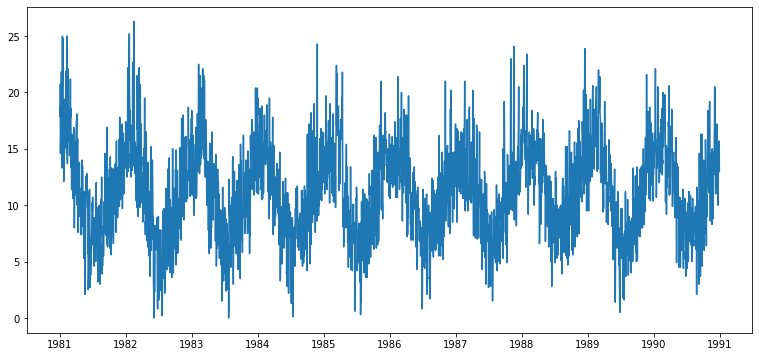

In [8]:
# 결측치가 있다면 이를 보간하기. 보간 기준은 time을 선택
ts1=ts1.interpolate(method='time')

# 보간 이후 결측치(NaN) 유무를 다시 확인
print(ts1[ts1.isna()])

# 다시 그래프를 확인
plt.plot(ts1)

구간 통계치(Rolling Statistics)를 시각화
1. [이동평균(MA)](https://econowide.com/3544) : 수의 집합에서 특정 크기의 부분 집합을 연속적으로 이동하며 산출한 평균 (부분집합의 크기에 맞추어 부분집합을 이룬 후 그 평균)
2. 이동표준편차

In [9]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

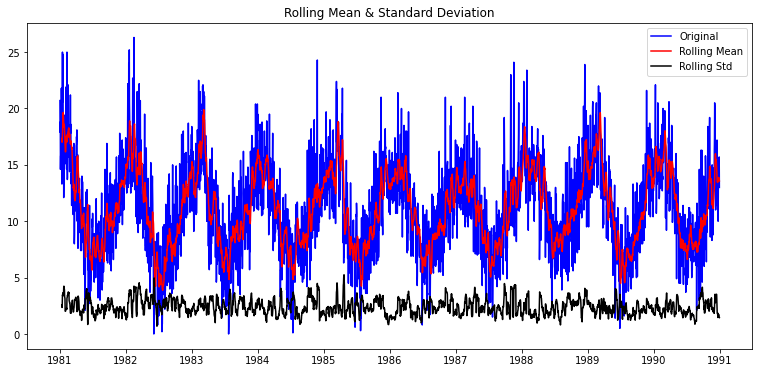

In [10]:
plot_rolling_statistics(ts1, window=12)

### 다른 시계열 데이터의 패턴과 비교 - International airlines passengers

In [11]:
dataset_filepath = os.getenv('HOME')+'/aiffel/stock_prediction/data/airline-passengers.csv' 
df = pd.read_csv(dataset_filepath, index_col='Month', parse_dates=True).fillna(0)  
print(type(df))
df.head()

<class 'pandas.core.frame.DataFrame'>


,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


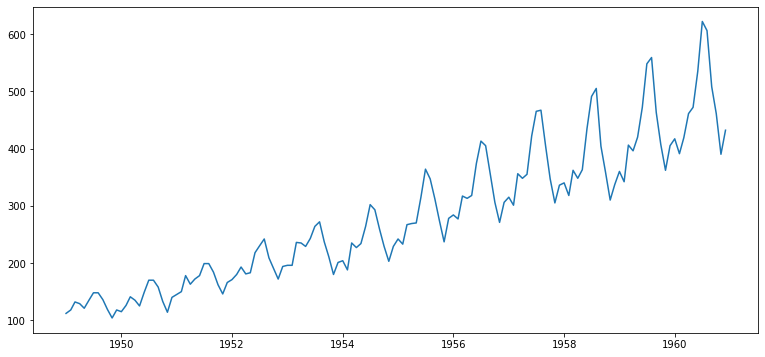

In [12]:
ts2 = df['Passengers']
plt.plot(ts2)

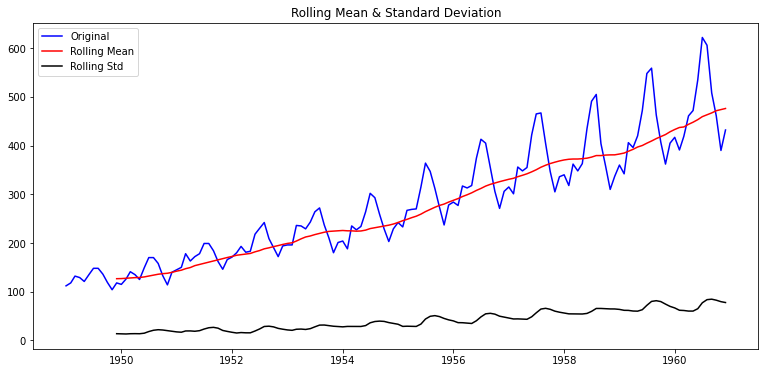

In [13]:
plot_rolling_statistics(ts2, window=12)

멜버룬 기온 데이터보다 항공사 승객 데이터가 더 안정적이지 않다.

## (2) Stationary 여부를 체크하는 통계적 방법

### Augmented Dickey-Fuller Test(ADF Test)

1. 주어진 시계열 데이터가 안정적이지 않다 라는 귀무가설(Null Hypothesis) 세우기  
2. 통계적 가설 검정 과정을 통해 이 귀무가설이 기각될 경우  
3. 이 시계열 데이터가 안정적이다 라는 대립가설(Alternative Hypothesis)를 채택하기

### statsmodels 패키지와 adfuller 메서드

- statsmodels : 통계검정, 시계열분석 등의 기능을 가진 패키지
- adfuller : 주어진 timeseries에 대한 Augmented Dickey-Fuller Test를 수행

In [14]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출하기
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력하기
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [15]:
augmented_dickey_fuller_test(ts1) # p-value 0.05미만 -> 귀무가설 기각

Results of Dickey-Fuller Test:
Test Statistic                   -4.444805
p-value                           0.000247
#Lags Used                       20.000000
Number of Observations Used    3629.000000
Critical Value (1%)              -3.432153
Critical Value (5%)              -2.862337
Critical Value (10%)             -2.567194
dtype: float64


In [16]:
augmented_dickey_fuller_test(ts2) 
# p-value 1에 가까움 -> 귀무가설이 옳다는 직접적인 증거는 아니지만 기각은 안함 -> 안정적인 시계열 데이터 아님

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


## (3) Non stationary를 Stationary하게 만들기

1. 정상적인 분석을 통해 보다 stationary 특성을 가지도록 기존의 시계열 데이터를 가공, 변형하는 시도
2. 시계열 분해(Time series decomposition) 기법을 적용

### 1) 보다 Stationary한 시계열 데이터로 가공해 가기

### 로그함수 변환
시간 추이에 따라 분산이 점점 커지는 경우 로그함수로 변환 하는 것이 도움이 된다.

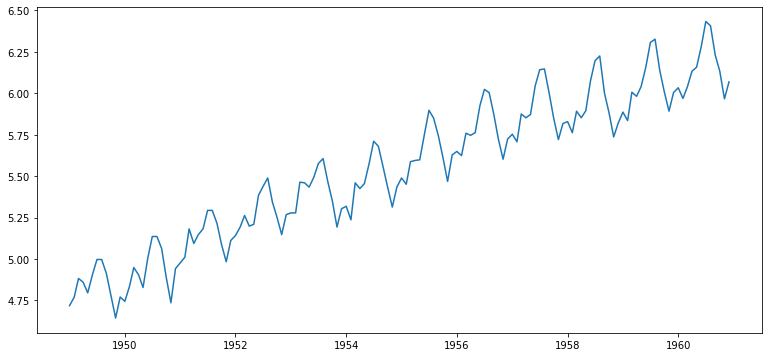

In [17]:
ts_log = np.log(ts2)
plt.plot(ts_log)

In [18]:
augmented_dickey_fuller_test(ts_log)
# p-value가 0.99에서 0.42로 낮아짐(시간 추이에 따른 분산이 일정해짐)

Results of Dickey-Fuller Test:
Test Statistic                  -1.717017
p-value                          0.422367
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


### Moving average 제거 - 추세(Trend) 상쇄하기

trend : 시간 추이에 따라 나타나는 평균값 변화  
변화되는 평균값을 제거해서 stationary -> Moving Average(rolling mean)을 구해 ts_log에서 빼주기

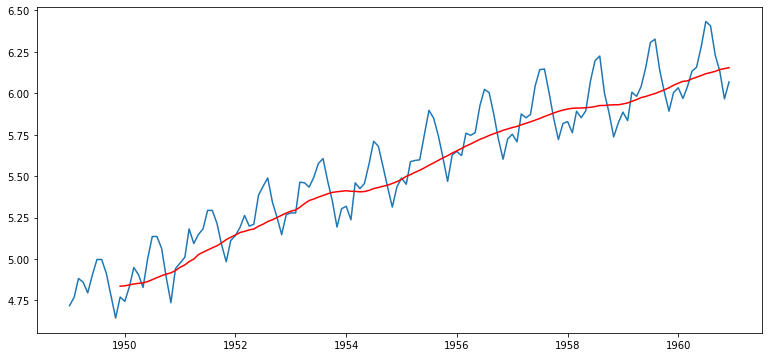

In [19]:
moving_avg = ts_log.rolling(window=12).mean() # moving average 구하기
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

In [20]:
ts_log_moving_avg = ts_log - moving_avg # 변화량 제거
ts_log_moving_avg.head(15)
# windows size = 12이므로 앞의 11개 데이터는 moving average가 계산이 되지 않아 nan값

Month
1949-01-01         NaN
1949-02-01         NaN
1949-03-01         NaN
1949-04-01         NaN
1949-05-01         NaN
1949-06-01         NaN
1949-07-01         NaN
1949-08-01         NaN
1949-09-01         NaN
1949-10-01         NaN
1949-11-01         NaN
1949-12-01   -0.065494
1950-01-01   -0.093449
1950-02-01   -0.007566
1950-03-01    0.099416
Name: Passengers, dtype: float64

In [21]:
# Dicky-Fuller Test시 에러 방지를 위해 결측치 제거
ts_log_moving_avg.dropna(inplace=True)
ts_log_moving_avg.head(15)

Month
1949-12-01   -0.065494
1950-01-01   -0.093449
1950-02-01   -0.007566
1950-03-01    0.099416
1950-04-01    0.052142
1950-05-01   -0.027529
1950-06-01    0.139881
1950-07-01    0.260184
1950-08-01    0.248635
1950-09-01    0.162937
1950-10-01   -0.018578
1950-11-01   -0.180379
1950-12-01    0.010818
1951-01-01    0.026593
1951-02-01    0.045965
Name: Passengers, dtype: float64

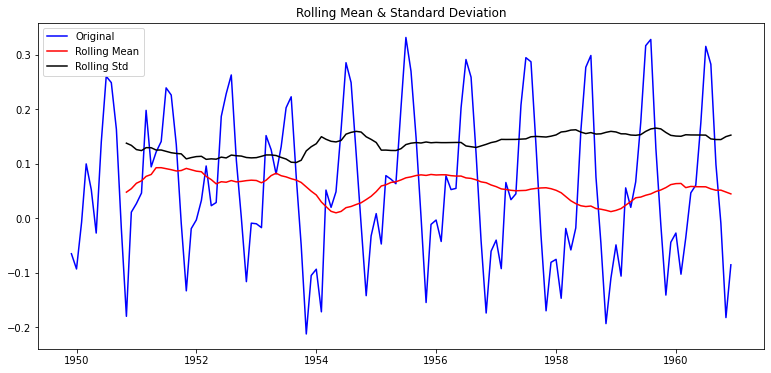

In [22]:
# 정성적 분석
plot_rolling_statistics(ts_log_moving_avg)

In [23]:
# 정량적 분석
augmented_dickey_fuller_test(ts_log_moving_avg)
# p-value = 0.02로 stationary 함

Results of Dickey-Fuller Test:
Test Statistic                  -3.162908
p-value                          0.022235
#Lags Used                      13.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64


window크기를 결정하는 것은 매우 중요함. 크기에 따라 p-value값이 변하기 때문.  
(ex. window=6으로 설정했을 때 p-value는 0.18이 나옴. 이 경우 stationary 하다고 볼 수 없음.)  
이 데이터셋의 경우 월 단위로 발생하는 시계열이므로 12개월 단위로 주기성이 있기 때문에 window=12가 적당하다는 것도 추측 가능.

### 차분(differencing) - 계절성(seasonality) 상쇄하기

계절성 : 패턴이 파악되지 않은 주기적 변화  
현재 스텝 값 - 직전 스텝 값 = 이번 스텝에서 발생한 변화량

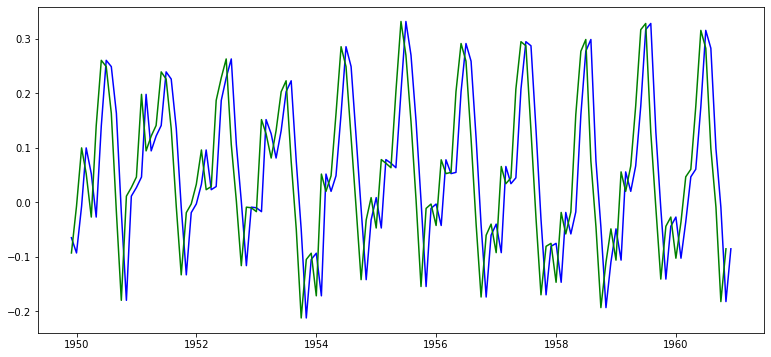

In [28]:
ts_log_moving_avg_shift = ts_log_moving_avg.shift(-1)

plt.plot(ts_log_moving_avg, color='blue')
plt.plot(ts_log_moving_avg_shift, color='green')

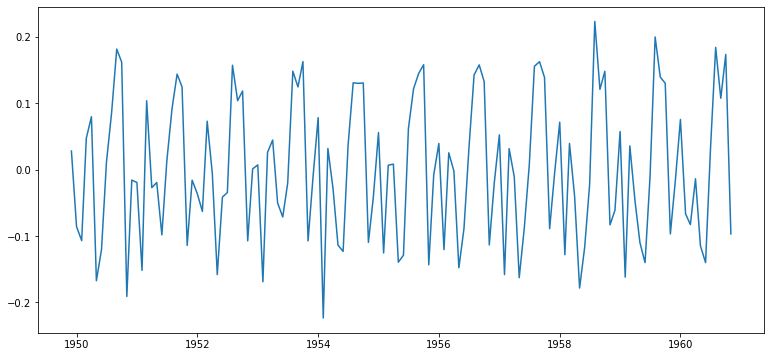

In [29]:
ts_log_moving_avg_diff = ts_log_moving_avg - ts_log_moving_avg_shift
ts_log_moving_avg_diff.dropna(inplace=True)
plt.plot(ts_log_moving_avg_diff)

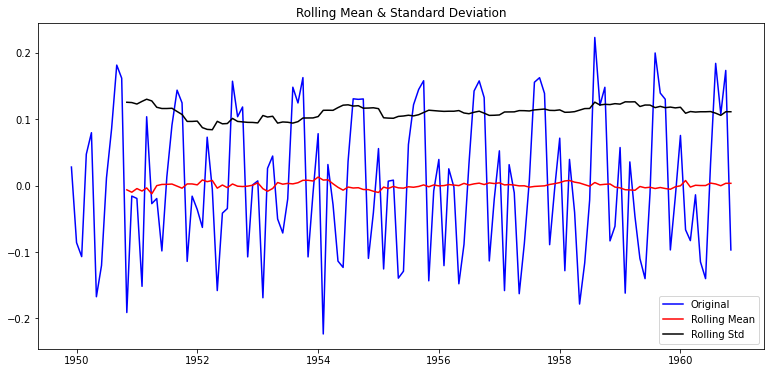

In [30]:
# 정성적 분석
plot_rolling_statistics(ts_log_moving_avg_diff)

In [31]:
# 정량적 분석
augmented_dickey_fuller_test(ts_log_moving_avg_diff)

Results of Dickey-Fuller Test:
Test Statistic                  -3.912981
p-value                          0.001941
#Lags Used                      13.000000
Number of Observations Used    118.000000
Critical Value (1%)             -3.487022
Critical Value (5%)             -2.886363
Critical Value (10%)            -2.580009
dtype: float64


differencing을 했는데 왜 p-value 값이 동일한 것인가..  
변화가 너무 근소해서 그런 것이라 추측한다. 보통 2차 차분부터는 변화가 없을 수 있는데 1차 차분에서 이렇게 값이 같게 나오는 것에 대한 이유를 정확하게 모르겠다. lms에는 1차 차분 후 p-value 값이 더 작아진다고 나와있는데 잘못 적혀있던 것이었을까,,  
해결방법 : ts_log_moving_avg_shift = ts_log_moving_avg.shift() -> (-1) 먼저 왼쪽으로 한칸 이동해야 한다. / ts_log_moving_avg_diff = ts_log_moving_avg - ts_log_moving_avg_shift[-1] -> [] 이동한 상태에서 shift를 빼주면 p-value값이 작아진다.

### 2) 시계열 분해(Time series decomposition)
statsmodels 라이브러리 안 seasonal_decompose 메서드 : 시계열 안에 존재하는 trend, seasonality를 직접 분리해 낼 수 있는 기능

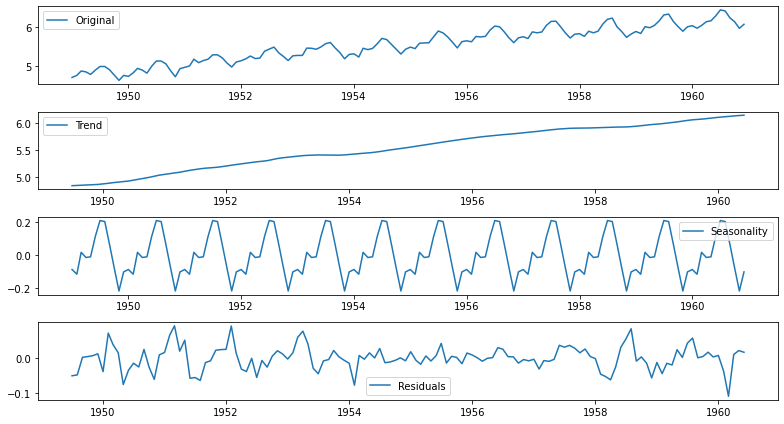

In [32]:
# 로그 변환
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log)

trend = decomposition.trend # 추세(시간 추이에 따라 나타나는 평균값 변화 )
seasonal = decomposition.seasonal # 계절성(패턴이 파악되지 않은 주기적 변화)
residual = decomposition.resid # 로그변환한 원본 - 추세 - 계절성
# trend + seasonal + residual = original

plt.rcParams["figure.figsize"] = (11,6)
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

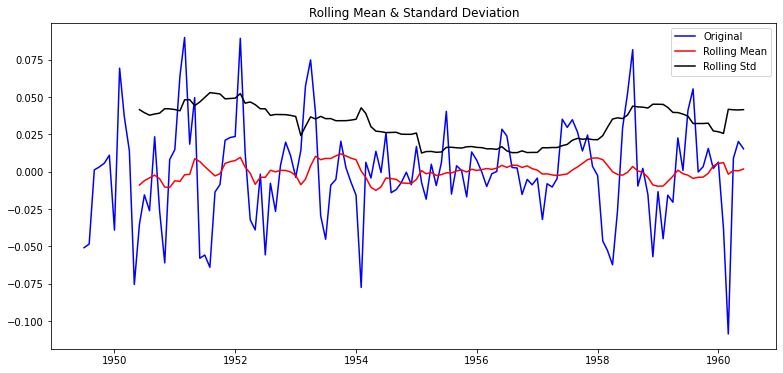

In [33]:
plt.rcParams["figure.figsize"] = (13,6)
plot_rolling_statistics(residual)

In [34]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)
# p-value = 2.885059e-08 -> 압도적으로 낮은 p-value. stationary함.

Results of Dickey-Fuller Test:
Test Statistic                -6.332387e+00
p-value                        2.885059e-08
#Lags Used                     9.000000e+00
Number of Observations Used    1.220000e+02
Critical Value (1%)           -3.485122e+00
Critical Value (5%)           -2.885538e+00
Critical Value (10%)          -2.579569e+00
dtype: float64


---------------

## 2. ARIMA 모델

## (1) 기본 개념
1. AR(자기회귀, Autoregressive)  
 - 과거 값들에 대한 회귀로 미래 값을 예측  
 - Y(t)가 이전 p개의 데이터 Y(t-1), Y(t-2), ... , Y(t-p)의 가중합으로 수렴한다고 보는 모델  
 - residual에 해당하는 부분을 모델링한다.  
2. MA(이동평균, Moving Average)  
 - Y(t)가 이전 q개의 예측오차값 e(t-1), e(t-2), ... , e(t-q)의 가중합으로 수렴한다고 보는 모델  
 - trend에 해당하는 부분을 모델링한다.  
3. I(차분 누적, Integration)  
 - Y(t)가 이전 데이터와 d차 차분의 누적(integration) 합이라고 보는 모델  
 - seasonality에 해당하는 부분을 모델링한다.

### 모수(parameter) p,d,q
1. 모수 p,d,q  
- p : 자기회귀 모형(AR)의 시차
- d : 차분 누적(I)의 횟수
- q : 이동평균 모형(MA)의 시차  
많은 시계열 데이터가 AR이나 MA 중 하나의 경향만 가지기 때문에 보통은 p + q < 2, p * q = 0인 값을 사용하여 p나 q 중 하나를 0으로 만들어 준다.  
    
  
2. ARIMA의 적절한 모수 p,d,q를 선택하는 방법  
- ACF : 시차(lag)에 따른 관측치들 사이의 관련성을 측정하는 함수. 주어진 시계열의 현재 값이 과거 값과 어떻게 상관되는지를 설명한다. ACF plot에서 X축은 상관계수, y축은 시차 수를 나타낸다.
- PACF : 다른 관측치의 영향력을 배제하고 두 시차의 관측치 간 관련성을 측정하는 함수

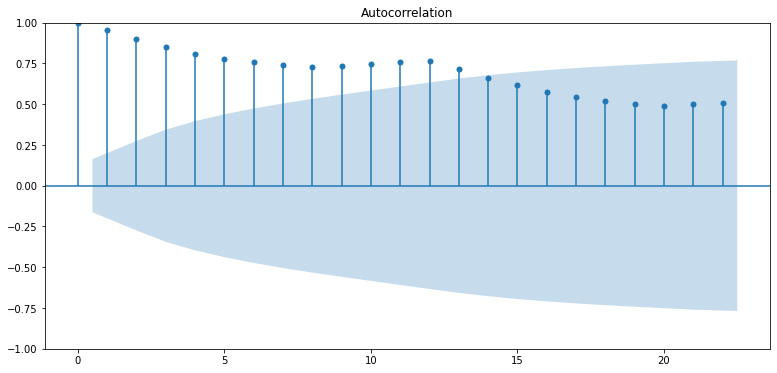

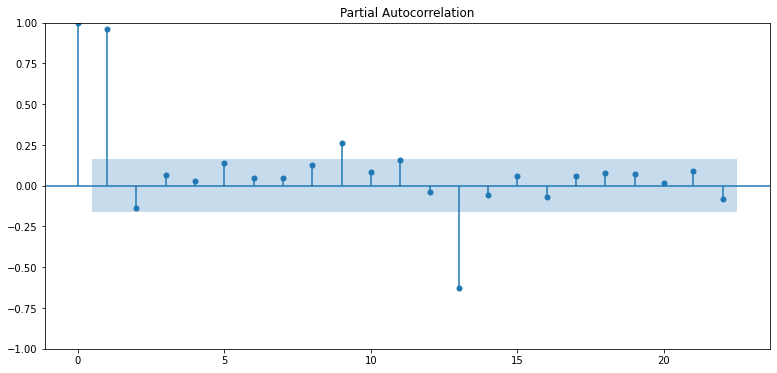

In [35]:
# 항공사 고객수 데이터로 시계열 만들기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

PACF 그래프를 볼 때 p=1이 적합하다. p가 2 이상인 구간에서 PACF는 거의 0에 가까워지고 있기 때문이다. PACF가 0이라는 의미는 현재 데이터와 p 시점 떨어진 이전의 데이터는 상관도가 0, 즉 아무 상관 없는 데이터이기 때문에 고려할 필요가 없다는 뜻이다.  
반면 ACF는 점차적으로 감소하고 있어서 AR(1) 모델에 유사한 형태를 보이고 있다. q에 대해서는 적합한 값이 없어 보인다. MA를 고려할 필요가 없다면 q=0으로 둘 수 있다.  
[p,q값 구하기](https://happy-chipmunk.tistory.com/96)

Results of Dickey-Fuller Test:
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


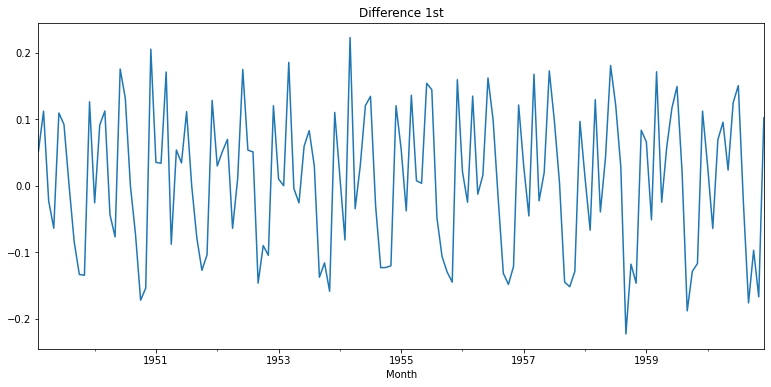

In [36]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:] # 첫번째는 자기자신이므로 같은 1이 나오기 때문에 제외
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                -8.196629e+00
p-value                        7.419305e-13
#Lags Used                     1.300000e+01
Number of Observations Used    1.280000e+02
Critical Value (1%)           -3.482501e+00
Critical Value (5%)           -2.884398e+00
Critical Value (10%)          -2.578960e+00
dtype: float64


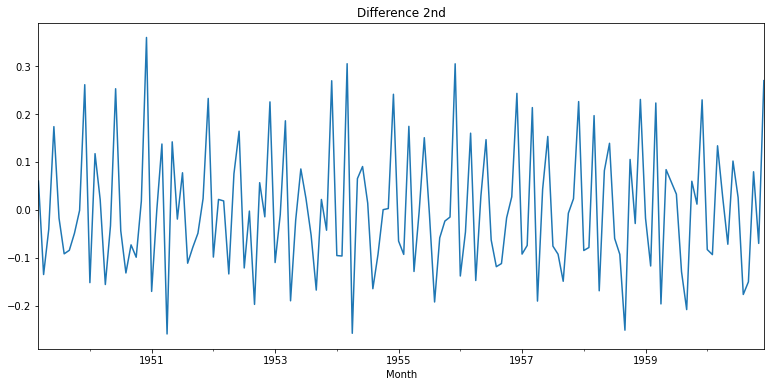

In [37]:
# 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

[1:] : 첫번째값[0]의 lag를 구할때는 자기자신과의 차이는 무조건 '1'이기 때문에 무시한다.  
1차 차분을 구했을 때 약간 애매한 수준의 안정화 상태를 보였다. 2차 차분을 구했을 때는 확실히 안정화 상태였지만  d=1로 먼저 시도해본다.

### 학습 데이터 분리

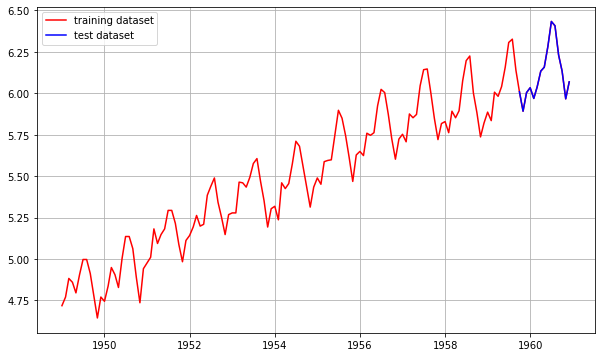

In [38]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

In [39]:
print(ts_log[:2])
print(train_data.shape)
print(test_data.shape)

Month
1949-01-01    4.718499
1949-02-01    4.770685
Name: Passengers, dtype: float64
(129,)
(15,)


## (2) ARIMA 모델 훈련과 추론

In [65]:
import warnings
warnings.filterwarnings('ignore') #경고 무시

from statsmodels.tsa.arima.model import ARIMA
# Build Model
model = ARIMA(train_data, order=(14, 1, 0)) # 모수 p,d,q 
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:             Passengers   No. Observations:                  129
Model:                ARIMA(14, 1, 0)   Log Likelihood                 219.942
Date:                Fri, 11 Nov 2022   AIC                           -409.883
Time:                        08:28:28   BIC                           -367.103
Sample:                    01-01-1949   HQIC                          -392.502
                         - 09-01-1959                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2651      0.081     -3.277      0.001      -0.424      -0.107
ar.L2         -0.0044      0.108     -0.040      0.968      -0.216       0.208
ar.L3          0.0021      0.046      0.046      0.9

[p,d,q 값(모수)을 구하는 방법](https://velog.io/@sjina0722/%EC%8B%9C%EA%B3%84%EC%97%B4%EB%B6%84%EC%84%9D-ARIMA-%EB%AA%A8%EB%8D%B8)  
1. ACF가 완만하게 떨어지는 그래프(non stationary) -> q=0 / PACF에서 양에서 음으로 뚝 떨어지는 구간 찾기 -> p=떨어지기 전 숫자
   PACF가 완만하게 떨어지는 그래프(non stationary) -> p=0 / ACF에서 양에서 음으로 뚝 떨어지는 구간 찾기 -> q=떨어지기 전 숫자
2. d=differencing 했을 때 p-value가 0.05미만이 되는 차분 횟수

내가 파악한 p,d,q 모수를 구하는 방법이고 이 데이터에서 p,d,q=1,1,0 이라고 생각했는데 왜 갑자기 p=14가 최적의 파라미터인지 이해가 되지 않는다.  
모수를 찾는 방법 중에는 auto.arima뿐만 아니라 다양한 방법이 있다고 한다. 아리마에 대해 더 깊게 공부하기에는 아직 부족한 것이 많아 잠시 미뤄두지만 다시 한 번 이 부분을 더 깊게 공부할 수 있는 날이 오길 바란다.

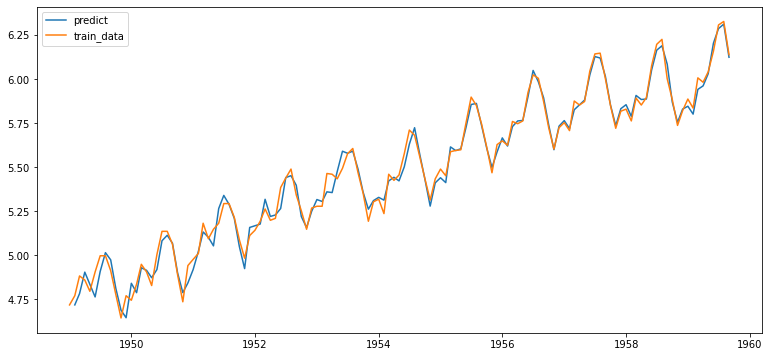

In [66]:
fitted_m = fitted_m.predict()
fitted_m = fitted_m.drop(fitted_m.index[0])
plt.plot(fitted_m, label='predict')
plt.plot(train_data, label='train_data')
plt.legend()

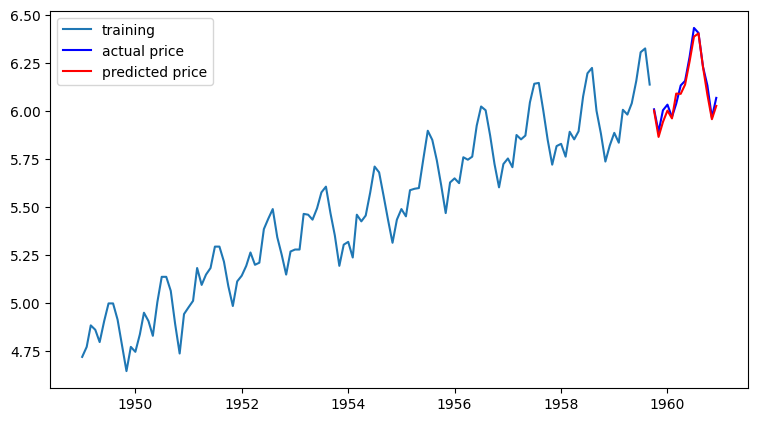

In [67]:
model = ARIMA(train_data, order=(14, 1, 0))  # p값을 14으로 테스트
fitted_m = model.fit() 
fc= fitted_m.forecast(len(test_data), alpha=0.05)  
# forcast() : 테스트 데이터 구간의 데이터를 예측
# alpha=0.05 -> conf(신뢰수준)=95% / alpha + conf = 1

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(9,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

[alpha](https://blog.naver.com/jiehyunkim/203272154)

In [68]:
# 시계열 데이터를 로그 변환하여 사용했으므로 다시 지수 변환해야 정확한 오차 계산 가능 
# np.exp()를 통해 전부 원본 스케일로 돌린 후 MSE, MAE, RMSE, MAPE를 계산
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  236.27939252509398
MAE:  12.55810531713422
RMSE:  15.371382258115045
MAPE: 2.76%


MAPE는 0에 가까울수록 회귀 모형의 성능이 좋다고 해석할 수 있다. 최종적으로 예측 모델의 메트릭으로 활용하기에 적당한 MAPE 기준으로 10% 정도의 오차율을 보인다. 모수에 따라 값이 바뀌므로 적당한 모수를 찾아보는 것도 방법 중 하나.  
p의 값이 작아질수록 MAPE 값은 커졌고, p의 값이 커질수록 MAPE 값이 작아지긴 했지만 14 이후로는 변화가 크게 나타나지는 않았다. p=14가 최적의 parameter라는 말인데 위에서도 그렇게 느꼈지만 ACF와 PACF를 통해 그 값을 알 수 있는 방법이 무엇인지 잘 모르겠다.  
[np.abs](https://rfriend.tistory.com/303)  
[MAPE](https://acdongpgm.tistory.com/102)